## Things to import, install and models to define

In [ ]:
# CLIP
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git

# REFCOCOG
# !gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
# !tar -xf /content/refcocog.tar.gz

# LAVIS
%pip install salesforce-lavis


In [1]:
import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam

import clip
import json
import cv2

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import locale

# from typing import Sequence, Union

locale.getpreferredencoding = lambda: 'UTF-8'


/home/gabri/Projects/University/DeepLearning/ProjectDL/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device='cpu'
  )

modelCLIP, preprocessCLIP = clip.load("RN50", device='cpu')


In [4]:
# SAM

import sys
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [5]:
from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


## Dataset

In [6]:
class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)
    
    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[2].item(), train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox  

In [7]:
REFCOCOG_PATH = "../Dataset/refcocog"

train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocessCLIP, tokenization=clip.tokenize)
val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocessCLIP, tokenization=clip.tokenize)
test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocessCLIP, tokenization=clip.tokenize)

train_dataloader = DataLoader(train_dataset, shuffle=False)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

## Functions

In [8]:
def print_bbox(image, bbox, title = ''):

  image_box = image.copy()
  plt.figure(figsize=(10,10))
  plt.title(title)

  for i in range(bbox[0], bbox[2]):
    for j in range(bbox[1], bbox[3]):
      image_box.putpixel((j, i), (225, 0, 0))

  plt.imshow(image_box)


In [9]:
def computeIntersection(bbox, BBOX):
  x_min = bbox[0]
  y_min = bbox[1]
  x_max = bbox[2]
  y_max = bbox[3]
  X_MIN = BBOX[0]
  Y_MIN = BBOX[1]
  X_MAX = BBOX[2]
  Y_MAX = BBOX[3]

  dx = min(x_max, X_MAX) - max(x_min, X_MIN)
  dy = min(y_max, Y_MAX) - max(y_min, Y_MIN)
  if (dx>=0) and (dy>=0):
      area = dx*dy
  else:
      area = 0
  return area

def computeAccuracy(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
    area2 = (BBOX[2]-BBOX[0])*(BBOX[3]-BBOX[1])
    union = area1 + area2 - intersection
    return intersection / union

def computePrecision(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1]) + 0.000001
    return intersection / area1


In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [11]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

In [12]:
def translate_center(center, key, w, h):
    if key==0:
      print('key=0')
    elif key==1:
      print('key=1')
    elif key==2:
      print('key=2')
      center[1] += int(w/4)
    elif key==3:
      print('key=3')
      center[1] += int(w/2)
    elif key==4:
      print('key=4')
    elif key==5:
      print('key=5')
      center[0] += int(h/4)
    elif key==6:
      print('key=6')
      center[0] += int(h/2)
    elif key==7:
      print('key=7')
    elif key==8:
      print('key=8')
      center[1] += int(w/4)     
    elif key==9:
      print('key=9')
      center[1] += int(w/2)
    elif key==10:
      print('key=10')
      center[0] += int(h/4)
    elif key==11:
      print('key=11')
      center[0] += int(h/4)
      center[1] += int(w/4) 
    elif key==12:
      # print('key=12')
      center[0] += int(h/4)
      center[1] += int(w/2)
    elif key==13:
      # print('key=13')
      center[0] += int(h/2)
    elif key==14:
      # print('key=14')      
      center[0] += int(h/2)
      center[1] += int(w/4)
    elif key==15:
      # print('key=15')
      center[0] += int(h/2)
      center[1] += int(w/2) 
    # elif key==16:
      # print('key=16')     
    elif key==17:
      # print('key=17')
      center[1] += int(w/6)
    elif key==18:
      # print('key=18')
      center[1] += int(w/3)
    elif key==19:
      # print('key=19')
      center[1] += int(w/2)
    elif key==20:
      # print('key=20')
      center[1] += int(2*w/3)
    elif key==21:
      # print('key=21')
      center[0] += int(h/6)
    elif key==22:
      # print('key=22')
      center[0] += int(h/6)
      center[1] += int(w/6)
    elif key==23:
      # print('key=23')
      center[0] += int(h/6)
      center[1] += int(w/3)
    elif key==24:
      # print('key=24')
      center[0] += int(h/6)
      center[1] += int(w/2)
    elif key==25:
      # print('key=25')
      center[0] += int(h/6)
      center[1] += int(2*w/3)
    elif key==26:
      # print('key=26')
      center[0] += int(h/3)
    elif key==27:
      # print('key=27')
      center[0] += int(h/3)
      center[1] += int(w/6)
    elif key==28:
      # print('key=28')
      center[0] += int(h/3)
      center[1] += int(w/3)
    elif key==29:
      # print('key=29')
      center[0] += int(h/3)
      center[1] += int(w/2)
    elif key==30:
      # print('key=30')
      center[0] += int(h/3)
      center[1] += int(2*w/3)
    elif key==31:
      # print('key=31')
      center[0] += int(h/2)
    elif key==32:
      # print('key=32')
      center[0] += int(h/2)
      center[1] += int(w/6)
    elif key==33:
      # print('key=33')
      center[0] += int(h/2)
      center[1] += int(w/3)
    elif key==34:
      # print('key=34')
      center[0] += int(h/2)
      center[1] += int(w/2)
    elif key==35:
      # print('key=35')
      center[0] += int(h/2)
      center[1] += int(2*w/3)
    elif key==36:
      # print('key=36')
      center[0] += int(2*h/3)
    elif key==37:
      # print('key=37')
      center[0] += int(2*h/3)
      center[1] += int(w/6)
    elif key==38:
      # print('key=38')
      center[0] += int(2*h/3)
      center[1] += int(w/3)
    elif key==39:
      # print('key=39')
      center[0] += int(2*h/3)
      center[1] += int(w/2)
    elif key==40:
      # print('key=40')
      center[0] += int(2*h/3)
      center[1] += int(2*w/3)

    return center


In [13]:
def sub_region(image, target, modelCLIP, preprocessCLIP):

  # CANDIDATE SUB-REGIONS
  image_pieces = [image]
  A, B = image.size

  # Immagine divisa in 2
  for i in range(3):
    im = image.crop((A/4*i,0,A/4*i+A/2,B))
    image_pieces.append(im)
  for j in range(3):
    im = image.crop((0,B/4*j,A,B/4*j+B/2))
    image_pieces.append(im)

  # # Immagine divisa in 4
  # for j in range(3):
  #   for i in range(3):
  #     im = image.crop((A/4*i,B/4*j,A/4*i+A/2,B/4*j+B/2))
  #     image_pieces.append(im)
  
  # # Immagine divisa in 9
  # for j in range(5):
  #   for i in range(5):
  #     im = image.crop((A/6*i,B/6*j,A/6*i+A/3,B/6*j+B/3))
  #     image_pieces.append(im)

  # ENCODING
  images = [preprocessCLIP(im) for im in image_pieces]
  images = torch.tensor(np.stack(images))

  with torch.no_grad():
    images_z = modelCLIP.encode_image(images).float()

  #TARGET
  target_caption = clip.tokenize(target)

  with torch.no_grad():
      target_caption_z = modelCLIP.encode_text(target_caption).float()
  
  # IMAGE SIMILARITIES
  im_sim = torch.Tensor(0)

  for im in images_z:
    similarity = cosine_similarity(im, target_caption_z)
    im_sim = torch.cat((im_sim, similarity), 0)

  topk_similarities, key = torch.topk(im_sim, 1, sorted=True)
  # print('TOP SIMILARITIES:', topk_similarities)

  return image_pieces[key[0].item()], key[0].item()


In [14]:
def center_da_gradcam(
  gradcam, colour_map, text_tokens: torch.Tensor = None, average: bool = True, visualize=False
):

  center = [0, 0]

  if average:

    if visualize==True:
      display(gradcam)
      print(gradcam.shape)
      # image = cv2.cvtColor(colour_map, cv2.COLOR_RGB2BGR)
      # cv2.imshow("image", gradcam)

      h, w, c = colour_map.shape

      # PRINT COLOUR MAP
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('COLOUR MAP')
      ax.imshow(gradcam)
      ax.imshow(colour_map)
      ax.axis('off')
      fig.tight_layout()
  
      # PRINT RED CHANNEL
      red_channel = np.zeros((h, w, 1))
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.02 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            red_channel[i][j][0] = 1            
      
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('RED CHANNEL')
      ax.imshow(red_channel)
      ax.axis('off')
      fig.tight_layout()

    # CALCULATE THE BBOX
    xs = []
    ys = []
    
    for i in range(colour_map.shape[0]):
      for j in range(colour_map.shape[1]):
        if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
          xs.append(i)
          ys.append(j)

    if len(xs)!=0:
      # center[0] = int(np.median(xs))
      # center[1] = int(np.median(ys))
      center[0] = int((max(xs)+min(xs))/2)
      center[1] = int((max(ys)+min(ys))/2)

  return center

In [282]:
def mergeGradcamImages(gradcams, image: Image):
    image_norm = np.float32(image) / 255
    size = np.array(image).shape
    output = np.ones((size[0], size[1]), np.float32)


    for i in gradcams:
        fig, ax = plt.subplots(1,1, figsize=(10, 10))
        gradcam = getAttMap(image_norm, i[0][1].cpu().numpy(), blur=False)
        ax.imshow(gradcam)

        # fig, ax = plt.subplots(1,2, figsize=(10, 10))


        gradcam = getAttMap(np.zeros(image_norm.shape), i[0][1].cpu().numpy(), blur=False)
        # ax[0].imshow(gradcam)


        processed = cv2.split(np.float32(gradcam))[0]
        processed = cv2.threshold(processed, 0.2, 1, cv2.THRESH_BINARY)[1]
        # ax[1].imshow(processed)

        output = cv2.bitwise_and(output, processed)
        output = cv2.threshold(output, 0.5, 1, cv2.THRESH_BINARY)[1]

    kernel = np.ones((5,5), np.uint8)
    output = cv2.erode(output, kernel, iterations=1)
    kernel = np.ones((5,5), np.uint8)
    output = cv2.dilate(output, kernel, iterations=2)
    output = cv2.threshold(output, 0.1, 1, cv2.THRESH_BINARY)[1]
    output = (output > 0).astype(np.uint8)

    # h,w  = output.shape

    # img = cv2.Mat((h, w), cv2.CV_8U)
    # img = cv2.fromarray(output)

    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.imshow(output)

    return output

In [302]:
def points_from_mask(mask: np.array, image: Image):
    print(mask.dtype)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.drawContours(np.zeros(np.float32(image).shape), contours, -1, (0, 255, 0), 3)

    points = []
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        points.append((cX, cY))
        cv2.circle(img, (cX, cY), 7, (255, 255, 255), -1)

    # fig, ax = plt.subplots(1,1, figsize=(10, 10))
    # ax.imshow(img)

    # display(points)

In [ ]:
points_from_mask(mask, image)

## Baseline

In [35]:
modelCLIP.eval()
device = 'cpu'

def check_baseline(loader, dataset, modelCLIP, preprocessCLIP, n_sample_to_check):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0
  
  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue
    
    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue


    sentences = dataset.getSentences(data_features)

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item()) 

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    gradcams = []
    outputs = []

    for target in sentences:
      print('TARGET:', target)
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0)
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt")
      gradcam, output = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        ) 
      print(len(gradcam))
      gradcams.append(gradcam)
      display(output)
      outputs.append(output)

      # point = center_da_gradcam(gradcam, image, text_tokens=text_tokens, average=True, visualize=True)
      # point = [point[1], point[0]]
      # points.append(point)

    return gradcams, image

    gradcam, colour_map = mergeGradcamImages(gradcams, image)
    point = center_da_gradcam(gradcam, colour_map, text_tokens=text_tokens, average=True, visualize=True)

    input_point = np.array(point)
    input_label = np.ones(len(sentences))


    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    for i, (mask, score) in enumerate(zip(masks, scores)):
      plt.figure(figsize=(10,10))
      plt.imshow(image)
      show_mask(mask, plt.gca())
      show_points(input_point, input_label, plt.gca())
      plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
      plt.axis('off')
      plt.show()  

    xs = []
    ys = []
        
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]
    print_bbox(image, bbox, 'FOUND BBOX')
    print_bbox(image, target_bbox, 'TARGET BBOX')

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)
    
    break

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')
    
  return #tot_accuracy/n_samples
  

In [251]:
gradcams, image = check_baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP, n_sample_to_check=10)

TARGET: a photo of the truck covered in the snow furthest to the right
1


tensor([[-0.4007,  0.3803]], grad_fn=<AddmmBackward0>)

TARGET: a photo of an old truck covered in snow except for the grill and door
1


tensor([[-0.3240,  0.2958]], grad_fn=<AddmmBackward0>)

In [ ]:
mask = mergeGradcamImages(gradcams, image)

uint8


[(492, 350), (623, 313), (441, 286), (547, 230)]

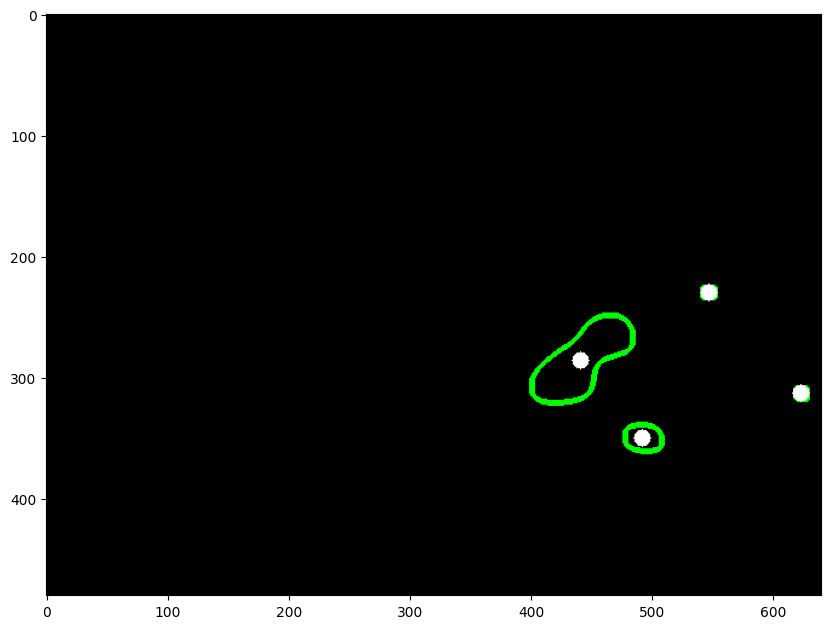

In [303]:

points_from_mask(mask, image)

In [ ]:
check_baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP, n_sample_to_check=3)

### Full Test

In [107]:
modelCLIP.cuda().eval()
device = 'cuda'

def baseline(loader, dataset, modelCLIP, preprocessCLIP):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0
  
  for data_features, data_bbox in loader:

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue
    
    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue

    sentences = dataset.getSentences(data_features)
    print('num sentences:', len(sentences))

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item()) 

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        ) 
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []
        
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')
    
  return #tot_accuracy/n_samples
  

In [ ]:
baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP)

## Variation with Fragmentation

In [120]:
modelCLIP.cuda().eval()
device = 'cuda'

def check_baseline4(loader, dataset, modelCLIP, preprocessCLIP, n_sample_to_check):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0
  
  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue
    
    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue


    sentences = dataset.getSentences(data_features)

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item()) 

    image = dataset.getImage(data_features)
    w, h = image.size

    img = np.array(image)
    predictor.set_image(img)

    points = []
    print('num sentences:', len(sentences))

    for sent in sentences:
      print('FULL SENTENCE:', sent)
      target = sent.split()
      target = target[3:10]
      target = ' '.join(target)
      print('TARGET:', target)
      image_restricted, key = sub_region(image, target, modelCLIP, preprocessCLIP)
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image_restricted).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image_restricted, text_tokens=text_tokens, average=True, visualize=True)
      point = translate_center(point, key, w, h)
      point = [point[1], point[0]]
      points.append(point)

    a = np.ones(len(sentences))
    input_point = np.array(points)
    input_label = np.array(a)

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    for i, (mask, score) in enumerate(zip(masks, scores)):
      plt.figure(figsize=(10,10))
      plt.imshow(image)
      show_mask(mask, plt.gca())
      show_points(input_point, input_label, plt.gca())
      plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
      plt.axis('off')
      plt.show()  

    xs = []
    ys = []
        
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    # bbox = [max([min(xs)-5,0]), max([min(ys)-5,0]), min([max(xs)+5, h]), min([max(ys)+5, w])]
    bbox = [min(xs), min(ys), max(xs), max(ys)]
    print_bbox(image, bbox, 'FOUND BBOX')
    print_bbox(image, target_bbox, 'TARGET BBOX')

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)
    
    break

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')
    
  return #tot_accuracy/n_samples
  

num sentences: 2
FULL SENTENCE: a photo of a apple desktop computer
TARGET: a apple desktop computer
key=3
FULL SENTENCE: a photo of the white imac computer that is also turned on
TARGET: the white imac computer that is also
key=3


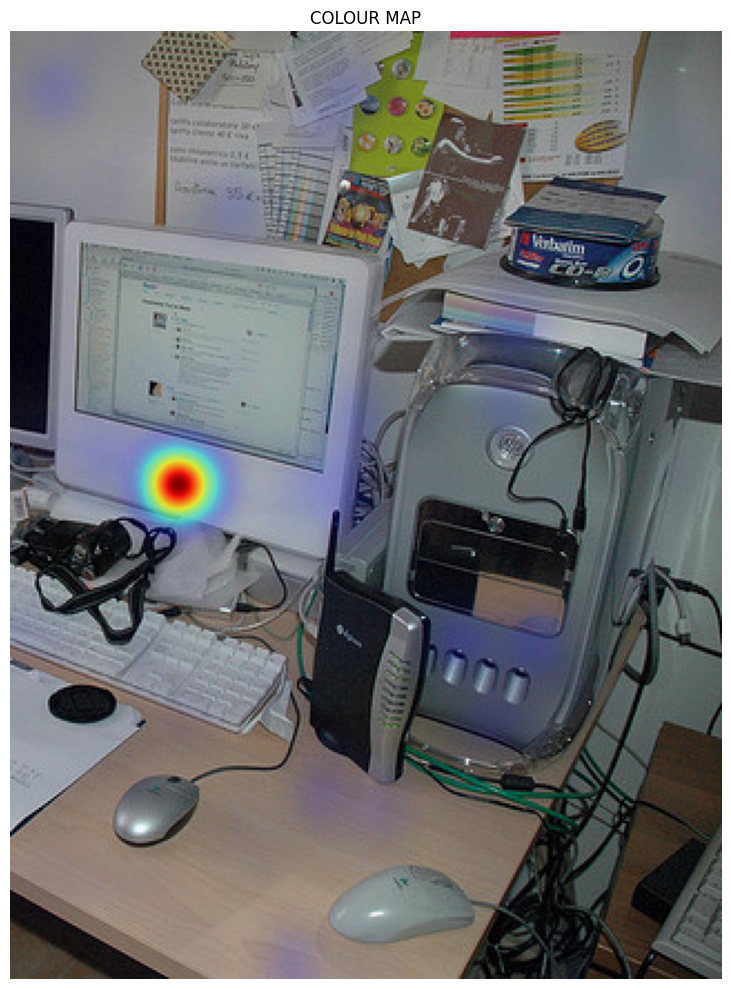

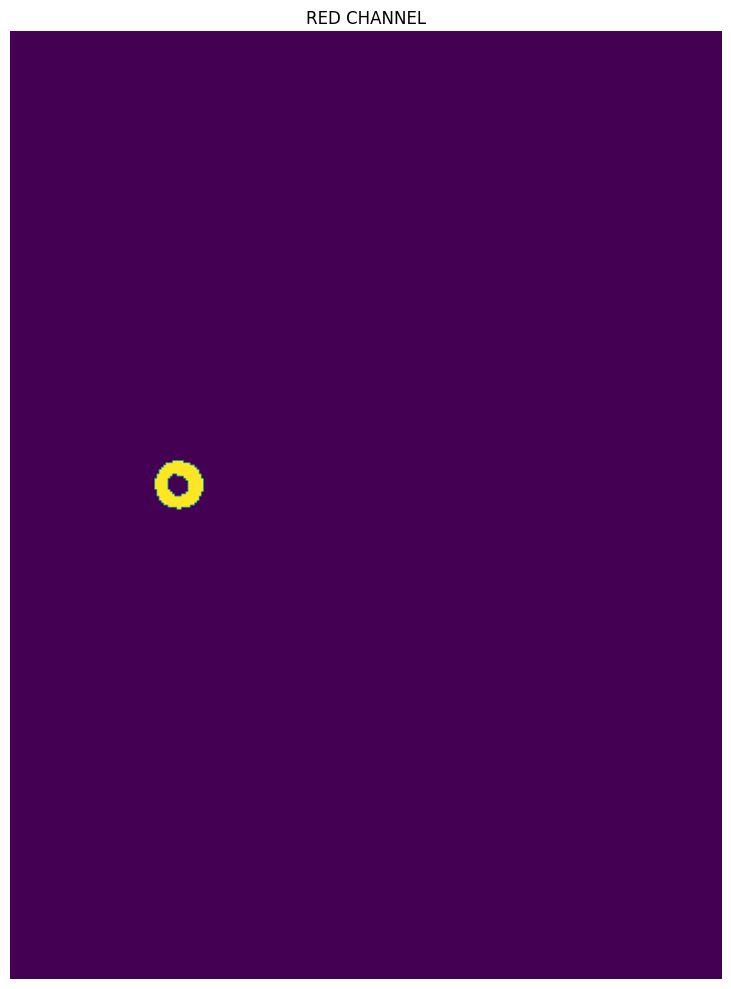

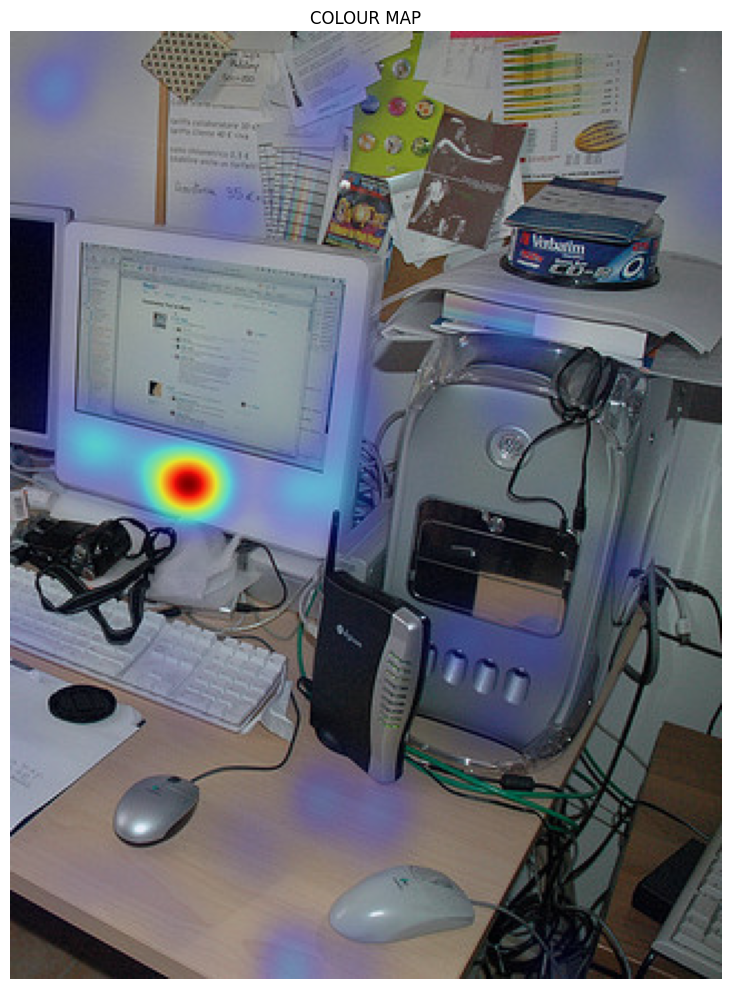

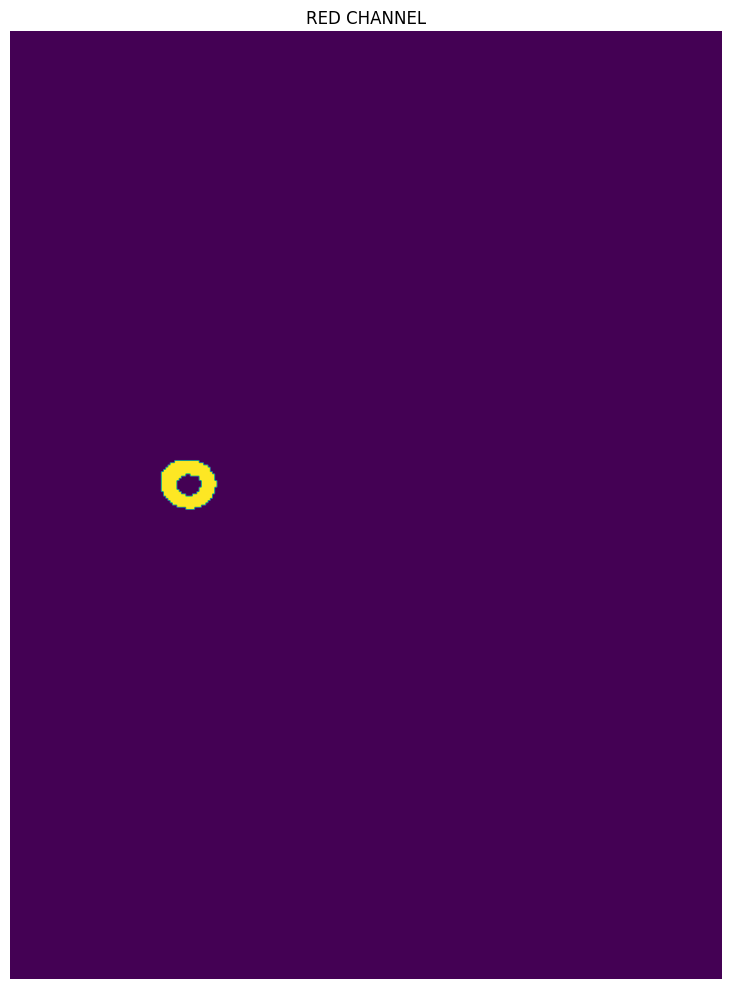

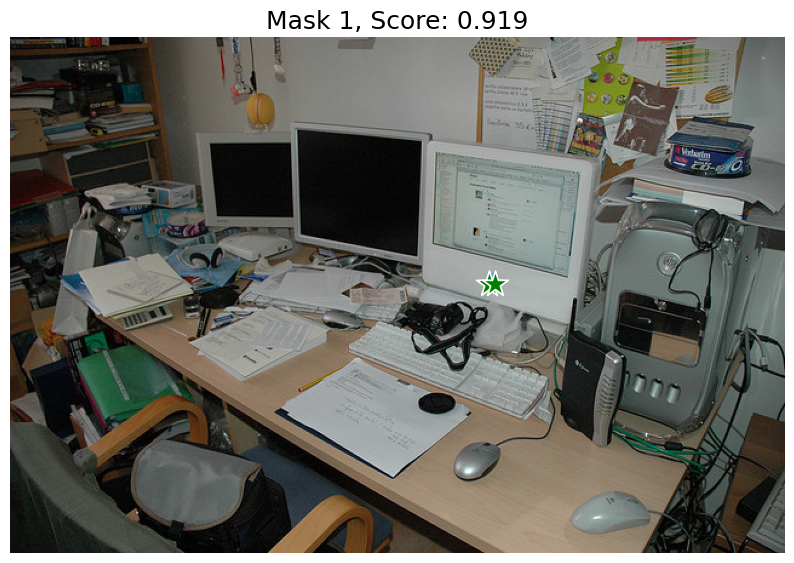

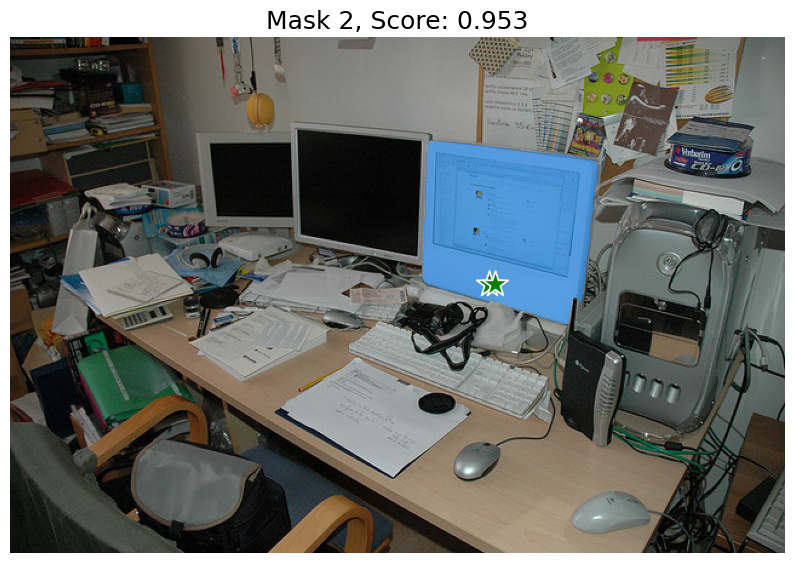

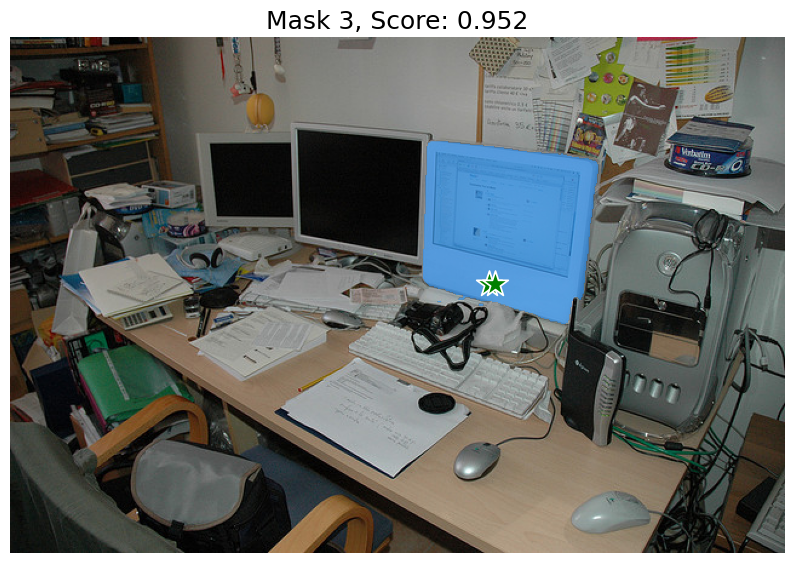

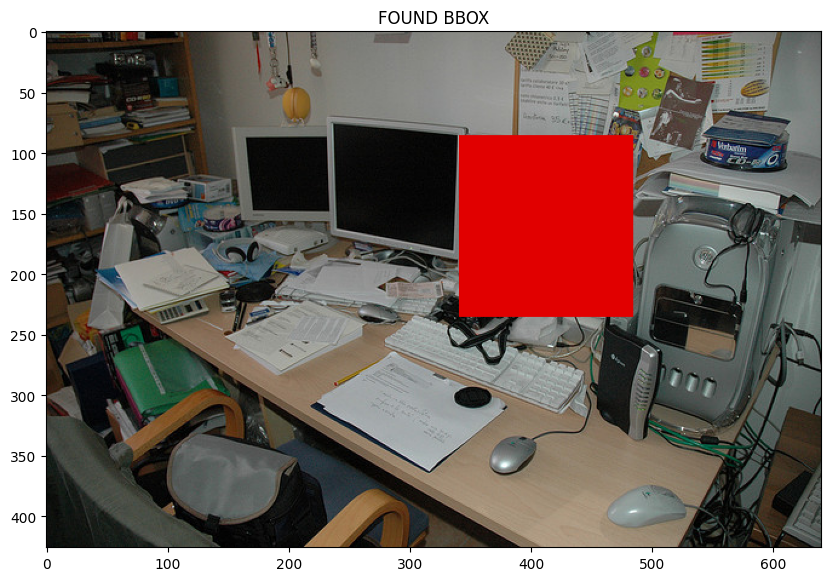

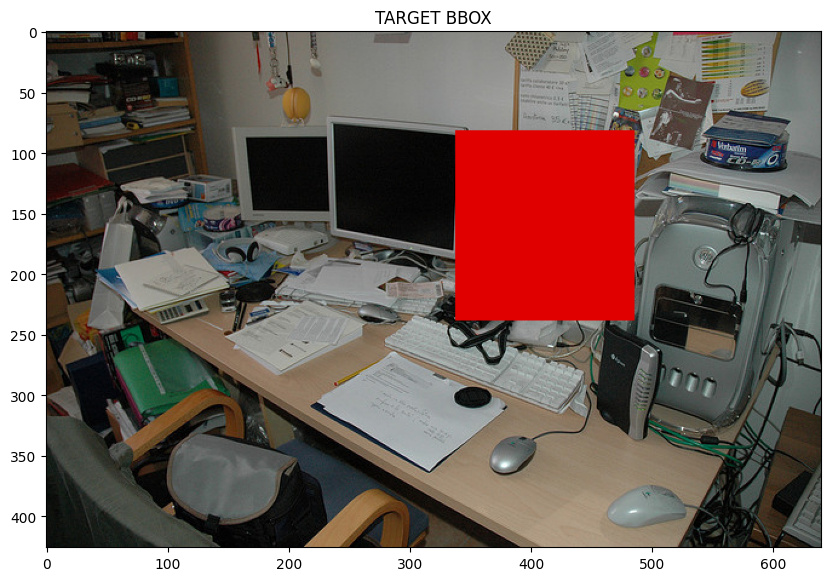

In [121]:
check_baseline4(test_dataloader, test_dataset, modelCLIP, preprocessCLIP, n_sample_to_check=3)

In [111]:
modelCLIP.cuda().eval()
device = 'cuda'

def check_baseline4(loader, dataset, modelCLIP, preprocessCLIP):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0
  
  for data_features, data_bbox in loader:

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue
    
    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue


    sentences = dataset.getSentences(data_features)

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item()) 

    image = dataset.getImage(data_features)
    w, h = image.size

    img = np.array(image)
    predictor.set_image(img)

    points = []
    print('num sentences:', len(sentences))

    for sent in sentences:    
      target = sent.split()
      target = target[3:10]
      target = ' '.join(target)
      image_restricted, key = sub_region(image, target, modelCLIP, preprocessCLIP)
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image_restricted).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image_restricted, text_tokens=text_tokens, average=True, visualize=False)
      point = translate_center(point, key, w, h)
      point = [point[1], point[0]]
      points.append(point)

    a = np.ones(len(sentences))
    input_point = np.array(points)
    input_label = np.array(a)

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []
        
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [max([min(xs)-5,0]), max([min(ys)-5,0]), min([max(xs)+5, h]), min([max(ys)+5, w])]

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')
    
  return #tot_accuracy/n_samples
  

In [112]:
check_baseline4(test_dataloader, test_dataset, modelCLIP, preprocessCLIP)

num sentences: 2
key=5
key=6
1) Precision: 0.9510489510156975 	Accuracy: 0.9420892213909671 

num sentences: 2
key=1
key=0
2) Precision: 0.9658378948693145 	Accuracy: 0.9658378948756843 

num sentences: 2
key=3
key=3
3) Precision: 0.9430194804812086 	Accuracy: 0.9430194805194805 

num sentences: 2
key=1
key=1
4) Precision: 0.781450463269736 	Accuracy: 0.7780537567639493 

num sentences: 2
key=3
key=3
5) Precision: 0.8758116882570047 	Accuracy: 0.8758116883116883 

num sentences: 2
key=1
key=1
6) Precision: 0.05901604278043307 	Accuracy: 0.058996482449669096 

num sentences: 2
key=1
key=6
7) Precision: 0.7239150507737163 	Accuracy: 0.6925795053003534 

num sentences: 2
key=5
key=0
8) Precision: 0.10235616006861566 	Accuracy: 0.10235616006928724 

num sentences: 2
key=1
key=1
9) Precision: 0.3693558673452562 	Accuracy: 0.36935586734693876 

num sentences: 2
key=6
key=3
10) Precision: 0.9589588130562429 	Accuracy: 0.9543133956024831 

num sentences: 2
key=3
key=1
11) Precision: 0.12847222

KeyboardInterrupt: ignored